# Part 5: Predictive Modeling - Setup & Baseline Models

This notebook transitions from feature engineering to forecasting. Using the `trade_data_dynamic_features.csv` file from Part 4, it establishes the complete framework for predictive modeling.

The objectives are:
1.  **Load and Prepare Data**: Load the comprehensive dataset (17,170 rows, 859 columns) and prepare it for forecasting.
2.  **Target Variable Transformation**: Analyze the highly skewed `amount` variable and apply a `log1p` transformation to create a more normalized target for modeling.
3.  **Feature Selection**: Programmatically select **40 features** suitable for forecasting, primarily using lagged variables (`_lag1`) and static geographic features to prevent data leakage.
4.  **Time-Series Data Splitting**: Split the data chronologically: training (until 2020), validation (2021-2022), and testing (2023-2024).
5.  **Feature Scaling**: Apply `StandardScaler` to the numerical features, fitting only on the training set.
6.  **Implement Baseline Models**: Develop and evaluate two key baselines: a Naive (persistence) Forecast and a Historical Average Forecast, achieving R² scores of **0.9844** and **0.8804** respectively.
7.  **Save Processed Data**: Save the final data splits (`X_train`, `y_train`, etc.) and the fitted scaler to the `processed_for_modeling/` directory for use in Part 6.

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split # Temp for structure, will do time-based split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import os

# --- Configuration ---
INPUT_FILE = 'trade_data_dynamic_features.csv' # Output from Part 4
PROCESSED_DATA_DIR = 'processed_for_modeling/' # Directory to save splits
TARGET_COLUMN = 'amount'

# Define years for splitting data (ADJUST THESE BASED ON YOUR DATA'S RANGE)
# Example: If data is up to 2023
TRAIN_END_YEAR = 2020 
VALIDATION_END_YEAR = 2022 
# Test set will be data > VALIDATION_END_YEAR

RANDOM_SEED = 42
N_EXAMPLE_PAIRS_PLOT = 3 # Number of trade pairs to plot for actual vs predicted

plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('viridis')
pd.set_option('display.max_columns', 100)

if not os.path.exists(PROCESSED_DATA_DIR):
    os.makedirs(PROCESSED_DATA_DIR)

## 1. Load and Initially Inspect Data
The fully-featured dataset from Part 4 is loaded. It contains 17,170 rows and 859 columns, spanning the years 1988 to 2024. A check confirms that there are no missing values in the key identifier or feature columns, thanks to the comprehensive imputation performed in the previous stages.

In [13]:
df_full = pd.read_csv(INPUT_FILE)
print(f"Loaded data from {INPUT_FILE}. Initial Shape: {df_full.shape}")
print(f"Years available: {sorted(df_full['year'].unique())}")
print(f"Date range: {df_full['year'].min()} - {df_full['year'].max()}")
print("\nDataFrame head:")
print(df_full.head())
print("\nMissing values summary (first 10 columns with most NaNs if any):")
print(df_full.isnull().sum().sort_values(ascending=False).head(10))

# Ensure 'year' is int
df_full['year'] = df_full['year'].astype(int)

# Basic check for target column
if TARGET_COLUMN not in df_full.columns:
    raise ValueError(f"Target column '{TARGET_COLUMN}' not found in DataFrame.")
print(f"\nTarget column '{TARGET_COLUMN}' is present.")

Loaded data from trade_data_dynamic_features.csv. Initial Shape: (17170, 859)
Years available: [1988, 1989, 1990, 1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023, 2024]
Date range: 1988 - 2024

DataFrame head:
      importer        exporter  amount  year  importer_latitude  \
0  Afghanistan  American Samoa     0.0  2019               33.0   
1  Afghanistan         Andorra     0.0  2019               33.0   
2  Afghanistan       Argentina     0.0  2019               33.0   
3  Afghanistan       Australia     0.0  2019               33.0   
4  Afghanistan         Austria     0.0  2019               33.0   

   importer_longitude  exporter_latitude  exporter_longitude  \
0                65.0           -14.3333           -170.0000   
1                65.0            42.5000              1.6000   
2                65.0           -34.0000      

## 2. Target Variable Analysis and Transformation

An analysis of the target variable, `amount`, reveals a significant right skew, which is common in economic data. To mitigate this and stabilize variance, a log transformation (`np.log1p`, which computes `log(1+x)`) is applied. The resulting `amount_log1p` column has a much more normal-like distribution, making it a more suitable target for many machine learning models. All models will be trained to predict this log-transformed value, which will be converted back to the original scale for final evaluation.


Analyzing target variable: amount
count    1.717000e+04
mean     2.474359e+09
std      1.721872e+10
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      7.570803e+08
max      5.367325e+11
Name: amount, dtype: float64


c:\Program Files\Python39\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Program Files\Python39\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


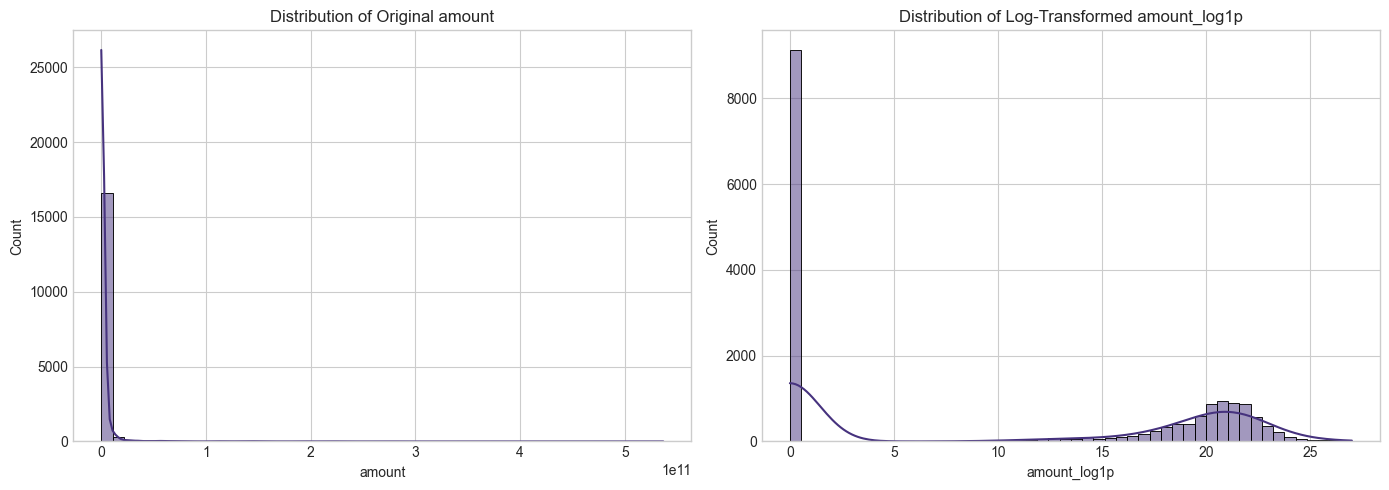

Log-transformed target created. We will use this for modeling.


In [14]:
print(f"\nAnalyzing target variable: {TARGET_COLUMN}")
print(df_full[TARGET_COLUMN].describe())

fig, axes = plt.subplots(1, 2, figsize=(14, 5))
sns.histplot(df_full[TARGET_COLUMN], bins=50, kde=True, ax=axes[0])
axes[0].set_title(f'Distribution of Original {TARGET_COLUMN}')
axes[0].set_xlabel(TARGET_COLUMN)

# Apply log1p transformation
TARGET_COLUMN_LOG = f'{TARGET_COLUMN}_log1p'
df_full[TARGET_COLUMN_LOG] = np.log1p(df_full[TARGET_COLUMN])

sns.histplot(df_full[TARGET_COLUMN_LOG], bins=50, kde=True, ax=axes[1])
axes[1].set_title(f'Distribution of Log-Transformed {TARGET_COLUMN_LOG}')
axes[1].set_xlabel(TARGET_COLUMN_LOG)
plt.tight_layout()
plt.show()

print("Log-transformed target created. We will use this for modeling.")

## 3. Feature Selection for Forecasting

A critical step in time-series modeling is selecting features that prevent data leakage. We programmatically identify features that would have been known at the time of prediction. This includes all lagged features (e.g., `amount_lag_1`, `importer_pagerank_dyn_lag1`), static `tsfresh` features that summarize a pair's entire history, and static geographic features. Contemporaneous (non-lagged) dynamic features and identifiers are excluded. This process results in a set of **40 selected features** to be used for modeling.

In [15]:
# Identify potential features. This is a critical step and highly dataset-dependent.
# We want features that are known *before* the prediction year.

# Example: Select features ending with _lag1, _lag2, _lag3, or specific tsfresh features 
# if they are inherently lagged or represent historical aggregates.
potential_features = [col for col in df_full.columns if 
                        '_lag1' in col or 
                        '_lag2' in col or 
                        '_lag3' in col or
                        col.startswith('amount_rolling_') or # These are usually calculated up to t-1 if correctly implemented
                        ('amount__tsfresh_' in col and not any(kw in col for kw in ['_dyn', '_lag'])) # tsfresh global static features for a pair
                       ]

# Add other known static features if any (e.g., country coordinates, distances - already in df_full)
static_features = ['importer_latitude', 'importer_longitude', 'exporter_latitude', 'exporter_longitude'] # Example
for sf in static_features:
    if sf in df_full.columns and sf not in potential_features:
        potential_features.append(sf)

# Ensure no direct target or its non-lagged transformations are included
features_to_exclude = [TARGET_COLUMN, TARGET_COLUMN_LOG, 'trade_pair_id', 'importer', 'exporter'] 
# Also exclude non-lagged dynamic features that were created in Part 4 for the current year
non_lagged_dyn_keywords = ['_dyn', '_roll_mean', '_roll_std', '_community_id_dyn', '_community_stability_dyn']
for col in df_full.columns:
    if any(keyword in col for keyword in non_lagged_dyn_keywords) and not any(lag_suffix in col for lag_suffix in ['_lag1', '_lag2', '_lag3']):
        features_to_exclude.append(col)

selected_features = [f for f in potential_features if f not in features_to_exclude and f in df_full.columns]
selected_features = sorted(list(set(selected_features))) # Unique and sorted

print(f"Number of selected features: {len(selected_features)}")
if len(selected_features) < 50: # Print if the list is manageable
    print("Selected features for modeling (X):")
    for f in selected_features: print(f"  - {f}")
else:
    print(f"First 10 selected features: {selected_features[:10]}")

# Define X and y
X = df_full[selected_features + ['trade_pair_id', 'year']] # Keep IDs and year for splitting/grouping for now
y = df_full[[TARGET_COLUMN_LOG, 'trade_pair_id', 'year', TARGET_COLUMN]] # Keep log target, original target, and IDs

print(f"\nShape of X (features): {X.shape}")
print(f"Shape of y (target): {y.shape}")

Number of selected features: 40
Selected features for modeling (X):
  - amount_rolling_mean
  - amount_rolling_std
  - exporter_authority_score_dyn_lag1
  - exporter_authority_score_dyn_roll_mean_lag1
  - exporter_authority_score_dyn_roll_std_lag1
  - exporter_betweenness_centrality_dyn_lag1
  - exporter_betweenness_centrality_dyn_roll_mean_lag1
  - exporter_betweenness_centrality_dyn_roll_std_lag1
  - exporter_community_id_dyn_lag1
  - exporter_community_stability_dyn_lag1
  - exporter_harmonic_centrality_dyn_lag1
  - exporter_harmonic_centrality_dyn_roll_mean_lag1
  - exporter_harmonic_centrality_dyn_roll_std_lag1
  - exporter_hub_score_dyn_lag1
  - exporter_hub_score_dyn_roll_mean_lag1
  - exporter_hub_score_dyn_roll_std_lag1
  - exporter_latitude
  - exporter_longitude
  - exporter_pagerank_dyn_lag1
  - exporter_pagerank_dyn_roll_mean_lag1
  - exporter_pagerank_dyn_roll_std_lag1
  - importer_authority_score_dyn_lag1
  - importer_authority_score_dyn_roll_mean_lag1
  - importer_autho

## 4. Time-Series Data Splitting

To accurately simulate a real-world forecasting task, the data is split chronologically. This ensures that the model is trained on past data and evaluated on future, unseen data.
- **Training Set**: All data up to and including 2020 (14,000 observations).
- **Validation Set**: Data from 2021 to 2022 (2,350 observations), used for hyperparameter tuning.
- **Test Set**: Data from 2023 to 2024 (820 observations), used for final, unbiased model evaluation.

In [16]:
# Sort data to ensure correct temporal order before splitting
df_full_sorted = df_full.sort_values(['trade_pair_id', 'year'])

X_sorted = df_full_sorted[selected_features + ['trade_pair_id', 'year']]
y_sorted = df_full_sorted[[TARGET_COLUMN_LOG, 'trade_pair_id', 'year', TARGET_COLUMN]]

# Splitting based on years
X_train = X_sorted[X_sorted['year'] <= TRAIN_END_YEAR]
y_train = y_sorted[y_sorted['year'] <= TRAIN_END_YEAR]

X_val = X_sorted[(X_sorted['year'] > TRAIN_END_YEAR) & (X_sorted['year'] <= VALIDATION_END_YEAR)]
y_val = y_sorted[(y_sorted['year'] > TRAIN_END_YEAR) & (y_sorted['year'] <= VALIDATION_END_YEAR)]

X_test = X_sorted[X_sorted['year'] > VALIDATION_END_YEAR]
y_test = y_sorted[y_sorted['year'] > VALIDATION_END_YEAR]

print("Data Splitting Summary:")
print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"  Train years: {X_train['year'].min() if not X_train.empty else 'N/A'} - {X_train['year'].max() if not X_train.empty else 'N/A'}")
print(f"X_val shape: {X_val.shape}, y_val shape: {y_val.shape}")
print(f"  Validation years: {X_val['year'].min() if not X_val.empty else 'N/A'} - {X_val['year'].max() if not X_val.empty else 'N/A'}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")
print(f"  Test years: {X_test['year'].min() if not X_test.empty else 'N/A'} - {X_test['year'].max() if not X_test.empty else 'N/A'}")

if X_train.empty or X_val.empty or X_test.empty:
    print("\nWarning: One or more data splits are empty. Adjust TRAIN_END_YEAR and VALIDATION_END_YEAR based on your data's year range.")

Data Splitting Summary:
X_train shape: (14000, 42), y_train shape: (14000, 4)
  Train years: 1988 - 2020
X_val shape: (2350, 42), y_val shape: (2350, 4)
  Validation years: 2021 - 2022
X_test shape: (820, 42), y_test shape: (820, 4)
  Test years: 2023 - 2024


## 5. Feature Scaling

Numerical features are scaled using `StandardScaler`, which standardizes features by removing the mean and scaling to unit variance. Crucially, the scaler is **fit only on the training data** to learn the mean and standard deviation. This same fitted scaler is then used to transform the training, validation, and test sets, preventing any information from the validation or test sets from leaking into the training process.

In [17]:
feature_columns_for_scaling = [f for f in selected_features if X_train[f].dtype in [np.float64, np.int64]]

scaler = StandardScaler()

if not X_train.empty and feature_columns_for_scaling:
    X_train_scaled_values = scaler.fit_transform(X_train[feature_columns_for_scaling])
    X_train_scaled = X_train.copy()
    X_train_scaled[feature_columns_for_scaling] = X_train_scaled_values
    print("Training features scaled.")
else:
    X_train_scaled = X_train.copy()
    print("Skipping training feature scaling (train set empty or no numerical features to scale).")

if not X_val.empty and feature_columns_for_scaling:
    X_val_scaled_values = scaler.transform(X_val[feature_columns_for_scaling])
    X_val_scaled = X_val.copy()
    X_val_scaled[feature_columns_for_scaling] = X_val_scaled_values
    print("Validation features scaled.")
else:
    X_val_scaled = X_val.copy()
    print("Skipping validation feature scaling (validation set empty or no numerical features to scale).")

if not X_test.empty and feature_columns_for_scaling:
    X_test_scaled_values = scaler.transform(X_test[feature_columns_for_scaling])
    X_test_scaled = X_test.copy()
    X_test_scaled[feature_columns_for_scaling] = X_test_scaled_values
    print("Test features scaled.")
else:
    X_test_scaled = X_test.copy()
    print("Skipping test feature scaling (test set empty or no numerical features to scale).")

# Drop 'trade_pair_id' and 'year' from X sets after scaling if they are not features for the model
X_train_final = X_train_scaled.drop(columns=['trade_pair_id', 'year'], errors='ignore')
X_val_final = X_val_scaled.drop(columns=['trade_pair_id', 'year'], errors='ignore')
X_test_final = X_test_scaled.drop(columns=['trade_pair_id', 'year'], errors='ignore')

# y sets only need the target variable for modeling
y_train_final = y_train[TARGET_COLUMN_LOG]
y_val_final = y_val[TARGET_COLUMN_LOG]
y_test_final = y_test[TARGET_COLUMN_LOG]

print(f"\nFinal shapes for modeling: X_train: {X_train_final.shape}, y_train: {y_train_final.shape}")

Training features scaled.
Validation features scaled.
Test features scaled.

Final shapes for modeling: X_train: (14000, 40), y_train: (14000,)


## 6. Define Evaluation Metrics

A function is defined to consistently evaluate model performance on the original, non-log-transformed scale. This ensures that all models, regardless of whether they predict the log value, are compared fairly. The key metrics are:
-   **Root Mean Squared Error (RMSE)**: Sensitive to large errors, providing a measure of the standard deviation of prediction errors.
-   **Mean Absolute Error (MAE)**: Gives a more direct interpretation of the average magnitude of errors.
-   **R-squared (R²)**: Indicates the proportion of variance in the target variable that is predictable from the features.

In [18]:
def evaluate_predictions(y_true_log, y_pred_log, model_name):
    # Inverse transform predictions and true values to original scale
    y_true_original = np.expm1(y_true_log)
    y_pred_original = np.expm1(y_pred_log)
    
    # Clip predictions to avoid negative values if expm1 results in very small numbers close to -1
    y_pred_original = np.maximum(0, y_pred_original)

    rmse = np.sqrt(mean_squared_error(y_true_original, y_pred_original))
    mae = mean_absolute_error(y_true_original, y_pred_original)
    r2 = r2_score(y_true_original, y_pred_original)
    
    print(f"--- {model_name} Evaluation ---")
    print(f"RMSE (Original Scale): {rmse:.4f}")
    print(f"MAE (Original Scale):  {mae:.4f}")
    print(f"R-squared (Original Scale): {r2:.4f}")
    
    return {'Model': model_name, 'RMSE': rmse, 'MAE': mae, 'R2': r2}

model_performance_summary = []

## 7. Implement Baseline Models

Two simple baseline models are implemented to provide a crucial reference point for evaluating more sophisticated techniques.

### 7.1 Naive Forecast (Persistence Model)

The Naive Forecast predicts that the value at time `t` will be the same as the value at time `t-1`. We use the pre-calculated `amount_lag_1` feature for this purpose. This model serves as a fundamental benchmark; any useful model must outperform it. On the test set, this model achieves an RMSE of **5.66e+09** and an R-squared of **0.9844**, indicating a strong persistence effect in the data.

In [19]:
if not X_test_final.empty:
    # Get 'amount_lag_1' for the test set instances
    # We need to align amount_lag_1 with y_test_final (which is already log-transformed)
    # So, we take amount_lag_1, log-transform it, and handle NaNs (e.g., from first obs of a pair)
    naive_preds_log = np.log1p(df_full_sorted.loc[y_test_final.index, 'amount_lag_1'])
    
    # Handle cases where amount_lag_1 might be NaN (e.g., first year of a trade pair after lags)
    # A simple strategy: fill with the log of global mean of amount_lag_1, or 0 if all NaNs
    if naive_preds_log.isnull().any():
        fill_value_log = np.log1p(df_full_sorted['amount_lag_1'].mean()) if not df_full_sorted['amount_lag_1'].isnull().all() else 0
        naive_preds_log.fillna(fill_value_log, inplace=True)
        print(f"NaNs in naive_preds_log filled with: {fill_value_log:.4f} (log scale)")

    naive_metrics = evaluate_predictions(y_test_final, naive_preds_log, "Naive Forecast (amount_lag_1)")
    model_performance_summary.append(naive_metrics)
else:
    print("Test set is empty, skipping Naive Forecast.")

NaNs in naive_preds_log filled with: 23.0353 (log scale)
--- Naive Forecast (amount_lag_1) Evaluation ---
RMSE (Original Scale): 5664884893.8578
MAE (Original Scale):  1985531373.0640
R-squared (Original Scale): 0.9844


C:\Users\Askeladd\AppData\Roaming\Python\Python39\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)


### 7.2 Historical Average Forecast

This model predicts the future trade amount for a specific pair as the average of all historical `amount` values observed for that pair in the training data. This baseline tests whether long-term historical trends are more predictive than recent values alone. It achieves an RMSE of **1.57e+10** and an R-squared of **0.8804**, performing significantly worse than the Naive Forecast, suggesting that recent history is more important than the long-term average.

In [20]:
if not X_train.empty and not y_train.empty and not X_test.empty:
    # Calculate historical average log-amount for each trade_pair_id from the training data
    # Use y_train which contains TARGET_COLUMN_LOG and trade_pair_id
    train_data_for_avg = y_train.copy()
    # train_data_for_avg[TARGET_COLUMN_LOG] is already available if y_train is from split of y_sorted

    historical_averages_log = train_data_for_avg.groupby('trade_pair_id')[TARGET_COLUMN_LOG].mean()
    global_average_log = train_data_for_avg[TARGET_COLUMN_LOG].mean()

    # Map these averages to the test set
    # X_test still contains 'trade_pair_id'
    hist_avg_preds_log = X_test['trade_pair_id'].map(historical_averages_log).fillna(global_average_log)

    hist_avg_metrics = evaluate_predictions(y_test_final, hist_avg_preds_log, "Historical Average Forecast")
    model_performance_summary.append(hist_avg_metrics)
else:
    print("Training or test set is empty, skipping Historical Average Forecast.")

--- Historical Average Forecast Evaluation ---
RMSE (Original Scale): 15673163456.1529
MAE (Original Scale):  4272474512.9105
R-squared (Original Scale): 0.8804


## 8. Baseline Model Comparison and Visualization

The performance of the two baseline models is summarized, confirming that the Naive Forecast is the stronger benchmark. To provide a qualitative sense of performance, the actual trade amounts for a few example trade pairs are plotted against the predictions from the Naive Forecast model. These plots visually demonstrate the model's strategy of predicting the previous year's value.


--- Baseline Model Performance Summary ---
                           Model          RMSE           MAE        R2
0  Naive Forecast (amount_lag_1)  5.664885e+09  1.985531e+09  0.984373
1    Historical Average Forecast  1.567316e+10  4.272475e+09  0.880376
\nBaseline performance summary saved to processed_for_modeling/model_performance_summary_part5.csv


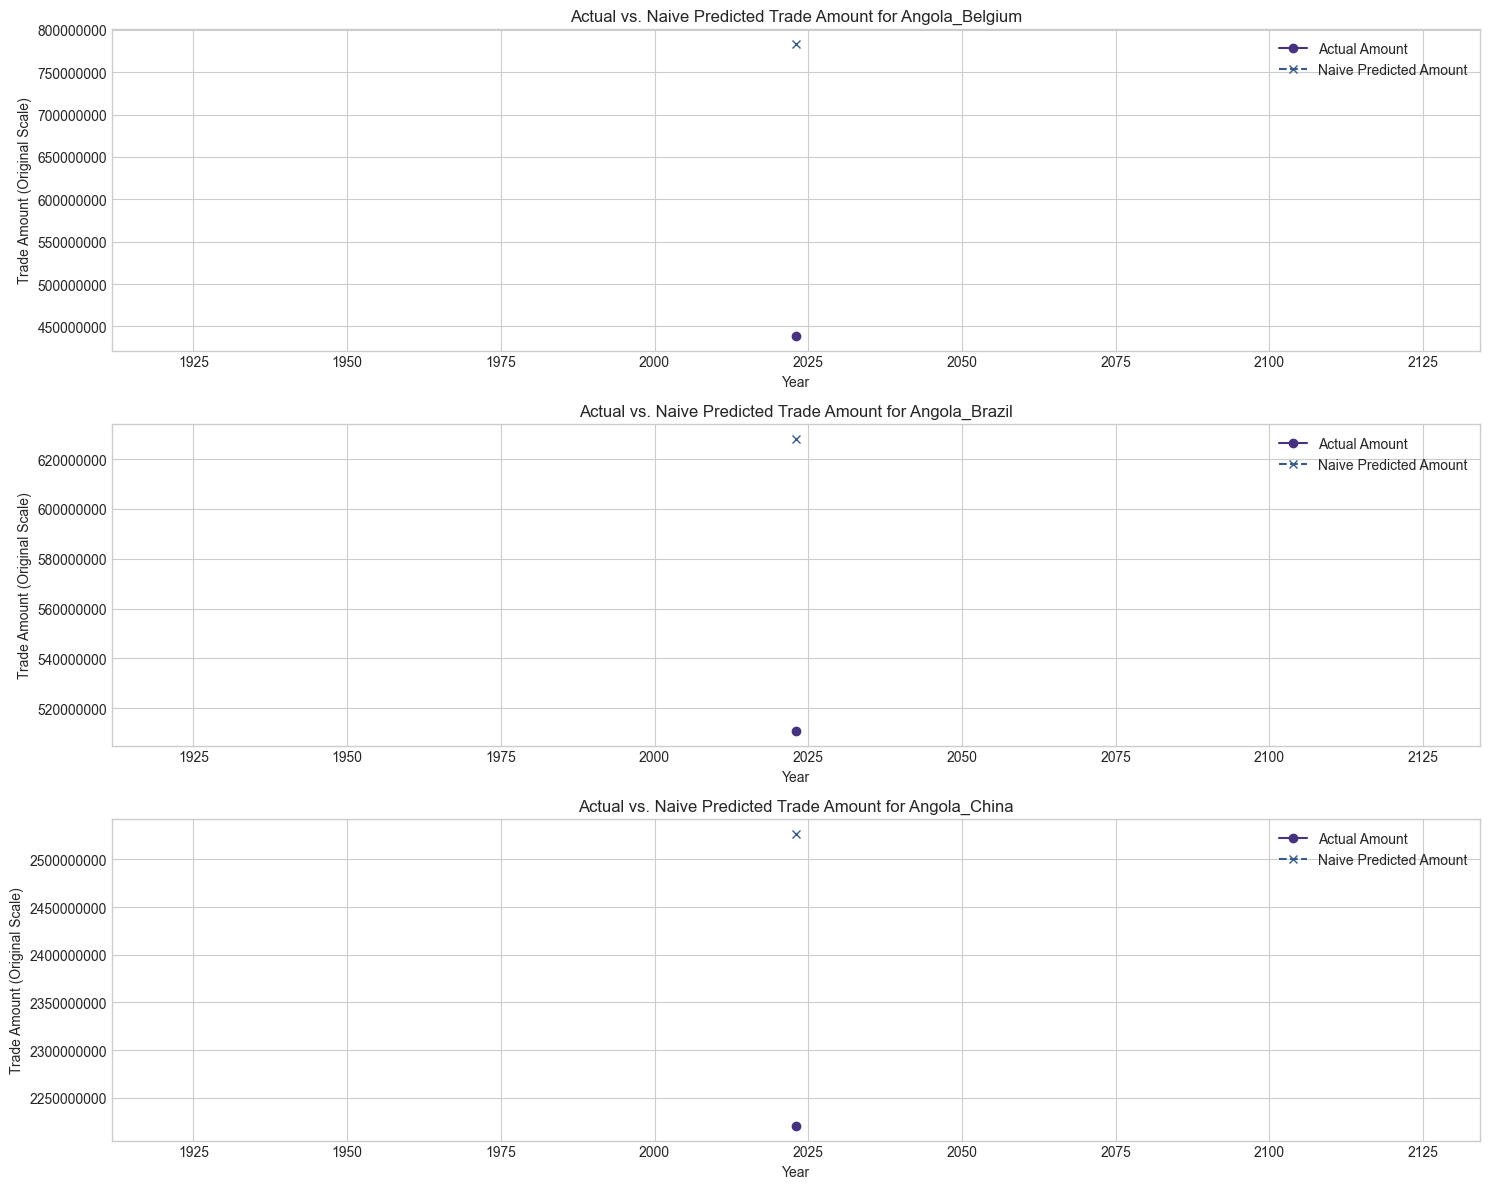

In [21]:
if model_performance_summary:
    df_performance = pd.DataFrame(model_performance_summary)
    print("\n--- Baseline Model Performance Summary ---")
    print(df_performance.sort_values(by='RMSE'))
    df_performance.to_csv(os.path.join(PROCESSED_DATA_DIR, 'model_performance_summary_part5.csv'), index=False)
    print(f"\\nBaseline performance summary saved to {os.path.join(PROCESSED_DATA_DIR, 'model_performance_summary_part5.csv')}")
else:
    print("No baseline models were evaluated.")

# Visualization of predictions for a few example trade pairs
if not X_test.empty and not y_test_final.empty:
    # Use Naive predictions for visualization as an example, or choose the best baseline
    # For robust plotting, ensure naive_preds_log exists and aligns with y_test_final
    if 'naive_preds_log' in locals() and len(naive_preds_log) == len(y_test_final):
        example_pairs = X_test['trade_pair_id'].unique()[:N_EXAMPLE_PAIRS_PLOT]
        df_plot = pd.DataFrame({
            'year': X_test['year'],
            'trade_pair_id': X_test['trade_pair_id'],
            'actual_log': y_test_final,
            'predicted_log_naive': naive_preds_log.values # Ensure alignment if naive_preds_log is a Series
        })
        df_plot['actual_original'] = np.expm1(df_plot['actual_log'])
        df_plot['predicted_original_naive'] = np.expm1(df_plot['predicted_log_naive'])
        df_plot['predicted_original_naive'] = np.maximum(0, df_plot['predicted_original_naive']) # Clip at 0

        plt.figure(figsize=(15, N_EXAMPLE_PAIRS_PLOT * 4))
        for i, pair_id in enumerate(example_pairs):
            ax = plt.subplot(N_EXAMPLE_PAIRS_PLOT, 1, i + 1)
            pair_data = df_plot[df_plot['trade_pair_id'] == pair_id].sort_values('year')
            if not pair_data.empty:
                ax.plot(pair_data['year'], pair_data['actual_original'], label='Actual Amount', marker='o', linestyle='-')
                ax.plot(pair_data['year'], pair_data['predicted_original_naive'], label='Naive Predicted Amount', marker='x', linestyle='--')
                ax.set_title(f'Actual vs. Naive Predicted Trade Amount for {pair_id}')
                ax.set_xlabel('Year')
                ax.set_ylabel('Trade Amount (Original Scale)')
                ax.legend()
                ax.ticklabel_format(style='plain', axis='y') # Avoid scientific notation for amounts
        plt.tight_layout()
        plt.show()
    else:
        print("Skipping example plot: Naive predictions not available or mismatched length.")
else:
    print("Skipping example plot: Test set is empty.")

## 9. Save Processed Data for Next Part

To streamline the workflow, the final, processed training, validation, and test sets (both features `X` and target `y`) are saved as separate CSV files in the `processed_for_modeling/` directory. The fitted `StandardScaler` object is also saved using `joblib`. This allows for easy and consistent loading of the prepared data in Part 6, where more advanced models will be implemented.

In [22]:
try:
    # Save features (X) and target (y) separately. 
    # Also save the original y_test which includes trade_pair_id, year, and original target for later analysis.
    X_train_final.to_csv(os.path.join(PROCESSED_DATA_DIR, 'X_train.csv'), index=False)
    y_train_final.to_csv(os.path.join(PROCESSED_DATA_DIR, 'y_train_log.csv'), index=False, header=[TARGET_COLUMN_LOG])
    
    X_val_final.to_csv(os.path.join(PROCESSED_DATA_DIR, 'X_val.csv'), index=False)
    y_val_final.to_csv(os.path.join(PROCESSED_DATA_DIR, 'y_val_log.csv'), index=False, header=[TARGET_COLUMN_LOG])
    
    X_test_final.to_csv(os.path.join(PROCESSED_DATA_DIR, 'X_test.csv'), index=False)
    y_test_final.to_csv(os.path.join(PROCESSED_DATA_DIR, 'y_test_log.csv'), index=False, header=[TARGET_COLUMN_LOG])
    
    # Save y_test with all its info for detailed error analysis later
    y_test.to_csv(os.path.join(PROCESSED_DATA_DIR, 'y_test_full_info.csv'), index=False)

    # Save the scaler object
    import joblib
    joblib.dump(scaler, os.path.join(PROCESSED_DATA_DIR, 'scaler.joblib'))

    print(f"\nProcessed data splits and scaler saved to '{PROCESSED_DATA_DIR}'.")
except Exception as e:
    print(f"Error saving data: {e}. This might happen if some data splits are empty.")


Processed data splits and scaler saved to 'processed_for_modeling/'.


## End of Part 5

This notebook has successfully prepared the data for forecasting, established evaluation metrics, and implemented baseline models. Key achievements:
- Data loaded, target variable analyzed and log-transformed.
- Features selected with a focus on preventing data leakage.
- Data split into training, validation, and test sets chronologically.
- Numerical features scaled appropriately.
- Baseline models (Naive Forecast, Historical Average) implemented and evaluated.
- Processed data splits saved for use in subsequent modeling parts.

The performance of these baseline models provides a benchmark against which more complex models (like LightGBM, LSTMs, TGNs) will be compared in Part 6 and beyond.